# Gate infidelity calculation
This notebook uses physical value to calculate the gate infidelity of a two-qubit spin gate for electrons in Penning trap. The motional mode is assumed to be the axial mode.

Parameters:
Magnetic field gradient 250 T/m at 50 $\mu \mathrm{m}$ above the surface.
$\frac{d^3B}{dz^3}=-7.2\times 10^9\ \mathrm{T/m}^3$.

We scan the axial frequency from 10 MHz to 1GHz.

A1 in data is amplitude/L, with L representing the unit size 150  $\mu \mathrm{m}$

In [15]:
using Unitful
import PhysicalConstants.CODATA2022:ħ,k_B,μ_B
using CairoMakie
using FileIO
using QuantumToolbox
using CSV
using DataFrames
include("../scripts/infidelities_funnctions.jl");

In [ ]:
function gradient_coupling(b,ω,m=1u"me")
    x0=zero_point_motion(ω,m=m)
    return u"MHz"(μ_B*b*x0/2ħ) # 2 accounts for the notation in [PRA 105, 022437 (2022)](https://link.aps.org/doi/10.1103/PhysRevA.105.022437).
end
function zero_point_motion(ω;m=1u"me")
    return sqrt(ħ/(2*m*ω))
end
function gradient_inhomogeneity_3()

zero_point_motion (generic function with 2 methods)

In [13]:
gradient_coupling(250u"T/m",2π*1u"GHz")

1.0550913573375198 MHz

## Anharmonicity
In principle, one should include the anharmonic terms into the Hamiltonian to get result. Here, for quick check, I treat the effect of anharmonicity as static frequency shifts for different amplitudes since the potential now have no low-order anharmonicity based on Kento's calculation and the tool for high order terms is not established yet in this repository.

In [71]:
df_frequency_shift=CSV.read(raw"..\data\frequency shift\A1_vs_omega_N10S6.csv",DataFrame)
base_frequency=2π*(10:10:1000)u"MHz"
δ=(df_frequency_shift.omega.-1.0)*(base_frequency./gradient_coupling.(250u"T/m",base_frequency))'
Ω=ones(size(δ));

In [75]:
N = 30  
na=0
ψ0 = basis(2,1) ⊗ basis(2,1) ⊗ fock(N,na) #↓↓
Sx=sigmax() ⊗ qeye(2) + qeye(2) ⊗ sigmax() 
infidelity_values_theoretical = [real(infidelity_static_motional_shift(δ,Ω,na,ptrace(ψ0,(1,2)),Sx,1)) for (δ,Ω) in zip(δ,Ω)];
# ptrace(ψ0,(1,2))
infidelity_values_numerical = [real(infidelity_static_motional_shift_numerical(Ω,δ,ψ0, progress_bar=Val(false))) for (δ,Ω) in zip(δ,Ω)];

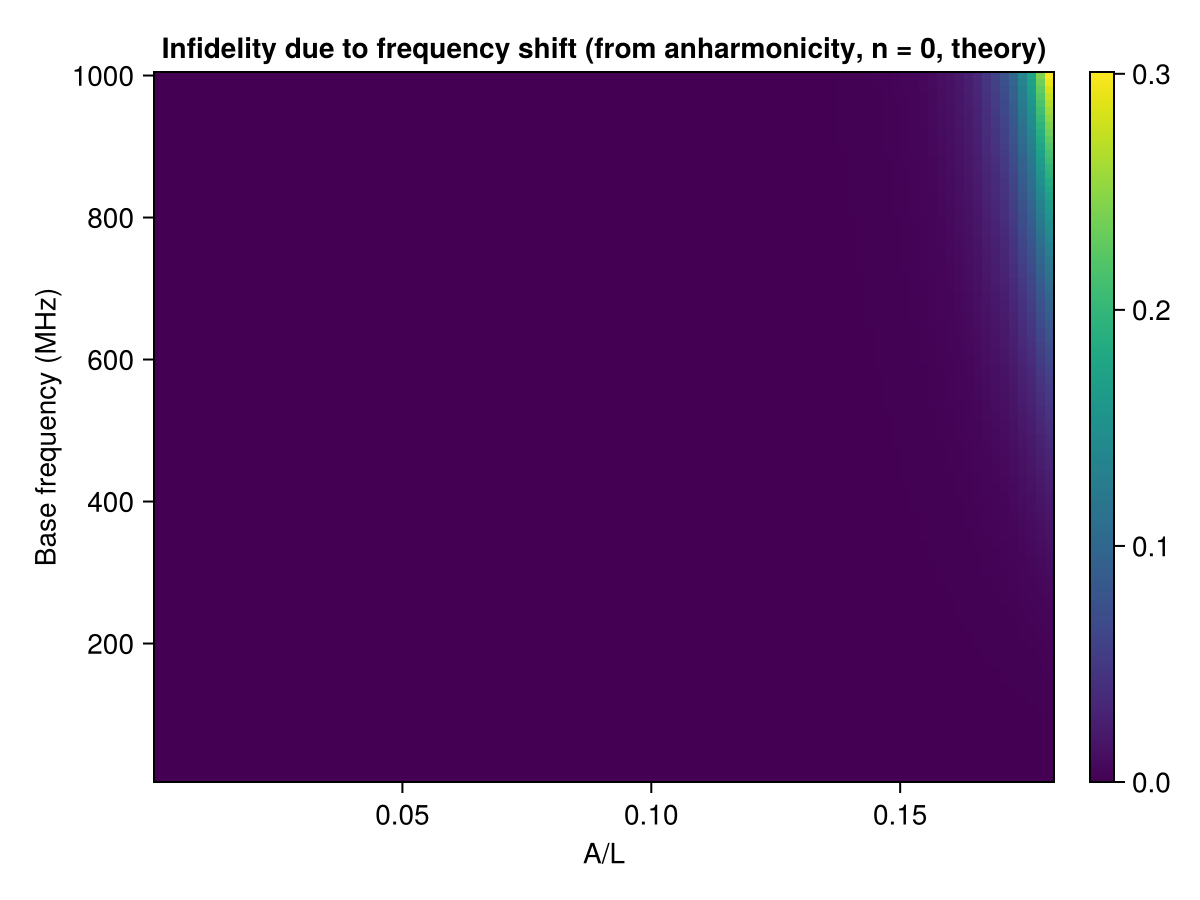

In [74]:
fig=Figure()
ax=Axis(fig[1,1],xlabel="A/L",ylabel="Base frequency (MHz)",title="Infidelity due to frequency shift (from anharmonicity, n = 0, theory)")
# ax2 = Axis(fig[1, 1], xaxisposition = :top")
# hidespines!(ax2)
# hideydecorations!(ax2)
hm=heatmap!(ax,(df_frequency_shift.A1),(base_frequency|>ustrip)/2pi,infidelity_values_theoretical)
Colorbar(fig[1,2],hm)
fig

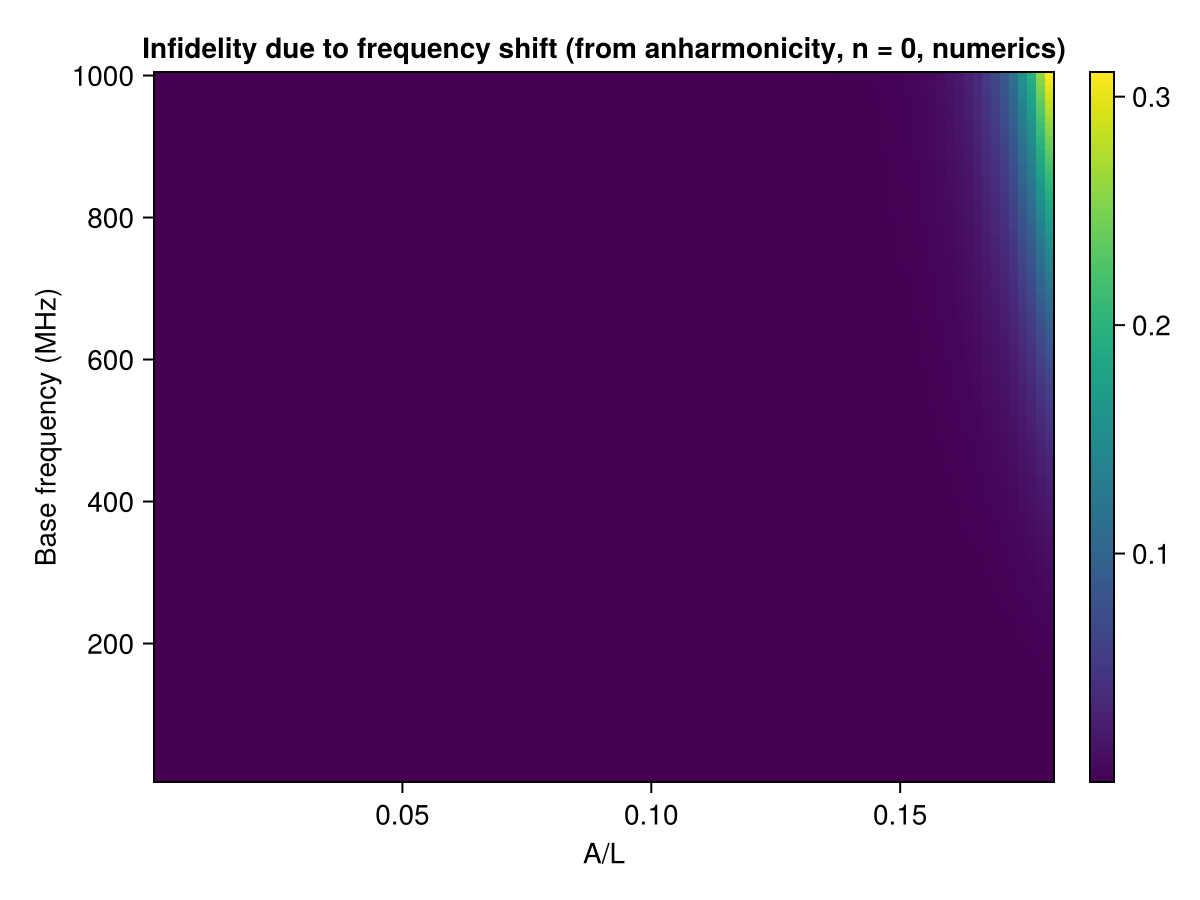

In [76]:
fig=Figure()
ax=Axis(fig[1,1],xlabel="A/L",ylabel="Base frequency (MHz)",title="Infidelity due to frequency shift (from anharmonicity, n = 0, numerics)")
# ax2 = Axis(fig[1, 1], xaxisposition = :top")
# hidespines!(ax2)
# hideydecorations!(ax2)
hm=heatmap!(ax,(df_frequency_shift.A1),(base_frequency|>ustrip)/2pi,infidelity_values_numerical)
Colorbar(fig[1,2],hm)
fig

## Magnetic gradient inhomogeneity 